In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
mpl.style.available
mpl.style.use('ggplot') 
from IPython.display import display, HTML
from itertools import cycle, islice
from matplotlib.font_manager import FontProperties
from ipywidgets import widgets
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from bokeh.plotting import figure, output_file, show
import datetime as dt 
from IPython.display import clear_output

from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.feature_selection import RFE

/home/duncan/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Customer demographic data initial exploration

In [2]:
## read customer demographic data
customers_df = pd.read_table("customer/000000_0",
                             header=None,
                             names = ['customer_id','churn_label',
                                      'gender','country','date_created',
                                      'YOB','premier'])
##convet churn label to 0 and 1
customers_df["churn_label"] = customers_df["churn_label"] - 1

##convert date_created to datetime object
customers_df["date_created"] = pd.to_datetime(customers_df["date_created"])

##convert year of birth to datetime object
customers_df["YOB"] = pd.to_datetime(customers_df["YOB"],format='%Y')

##insert account age in days, most recent order in receipts data is 30/3/2014
latest_date = dt.date(2014,3,30)
customers_df["account_age"] = (latest_date - customers_df["date_created"]).dt.days

##insert account age in months, better for plotting
latest_date = dt.date(2014,3,30)
customers_df["account_age_months"] = np.ceil((latest_date - customers_df["date_created"]).dt.days/30)

##insert customer age in years
customers_df["customer_age"] = np.floor((latest_date - customers_df["YOB"]).dt.days/365)

In [3]:
customers_df.head()

,customer_id,churn_label,gender,country,date_created,YOB,premier,account_age,account_age_months,customer_age
0,1852043,1,F,UK,2005-03-02 19:35:50,1986-01-01,0,3314,111.0,28.0
1,1825138,0,F,UK,2005-11-25 20:32:39,1981-01-01,0,3046,102.0,33.0
2,863960,0,M,UK,2005-05-12 13:04:19,1983-01-01,0,3243,109.0,31.0
3,585725,0,F,UK,2006-03-23 16:59:31,1976-01-01,6,2928,98.0,38.0
4,1773666,1,F,UK,2006-04-20 18:42:44,1990-01-01,0,2900,97.0,24.0


## Churned customers have shorter account age on average

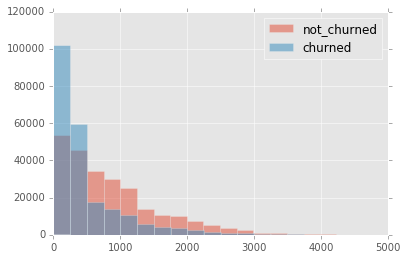

Average account age for not churned is: 860.6834839193685
Average account age for churned is: 486.83522621154583


In [4]:
x = customers_df[(customers_df.churn_label == 0) 
             & (customers_df.account_age < 6000)]["account_age"]

y = customers_df[(customers_df.churn_label == 1) 
             & (customers_df.account_age < 6000)]["account_age"]

plt.hist(x, alpha=0.5, label='not_churned',bins=20)
plt.hist(y, alpha=0.5, label='churned',bins=20)
plt.legend(loc='best')
plt.show()
print('Average account age for not churned is:',x.mean())
print('Average account age for churned is:',y.mean())

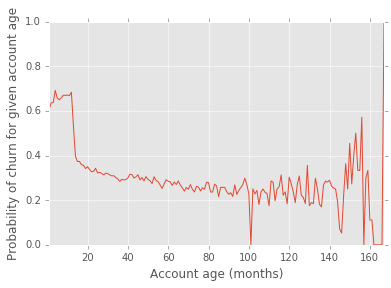

In [5]:
customers_df[(customers_df.account_age_months < 200)].groupby("account_age_months")["churn_label"].mean().plot()

plt.xlabel("Account age (months)")
plt.ylabel("Probability of churn for given account age")

## Massive decrease in churn once account is over 12 months old, is this just an artifact of the way churn is defined?

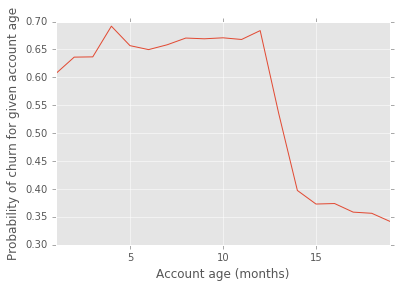

In [6]:
customers_df[(customers_df.account_age_months < 20)].groupby("account_age_months")["churn_label"].mean().plot()

plt.xlabel("Account age (months)")
plt.ylabel("Probability of churn for given account age")

## A higher proportion of teenage and older customers churn

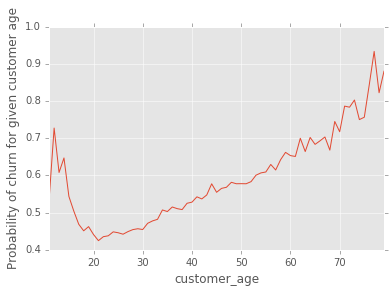

In [7]:
customers_df[(customers_df.customer_age < 80)
             & (customers_df.customer_age > 10)].groupby("customer_age")["churn_label"].mean().plot()

plt.ylabel("Customer age (years)")
plt.ylabel("Probability of churn for given customer age")

## Gender doesn't seem to affect churn

In [8]:
print("Proportion of female customers",len(customers_df[customers_df.gender == "F"])/len(customers_df))

print("Probability churn given female",len(customers_df[(customers_df.churn_label == 1) 
             & (customers_df.gender == "F")])/len(customers_df[(customers_df.gender == "F")]))

print("Probability churn given male",len(customers_df[(customers_df.churn_label == 1) 
             & (customers_df.gender == "M")])/len(customers_df[(customers_df.gender == "M")]))
            

Proportion of female customers 0.7565534945944968
Probability churn given female 0.4734220203087926
Probability churn given male 0.49346065472082196


## Add features from reciepts data

In [87]:
#####################################################
######## Read all receipt files #####################
#####################################################
dfs_to_concat = []

for i in range(0,3):                                                            
    dfs_to_concat.append(
        pd.read_table("receipts/00000%d_0" % i,header=None,names = ['customer_id','product_id',
                                                            'source_id','division_id','item_qty',
                                                            'signal_datetime','receipt_id','price']))
receipts_df = pd.concat(dfs_to_concat)

#convert signal date to datetime object
receipts_df["signal_datetime"] = pd.to_datetime(receipts_df["signal_datetime"])
receipts_df["date"] = receipts_df["signal_datetime"].dt.date

##create order summary dataframe, 
##this contains the number of items bought and the total value of the order

##group all orders (groupby columns are not aggregated) and sum over item_qty and price

order_sum_df = receipts_df.groupby(
    ['receipt_id','signal_datetime','customer_id']).sum().reset_index()

##drop product_id, source_id, division_id as they are now meaningless
order_sum_df.drop(['product_id','source_id', 'division_id'], axis = 1, inplace = True)

order_sum_df["date"] = order_sum_df["signal_datetime"].dt.date

##create a dataframe that is a summary of all of a customers orders
customer_order_sum_df = receipts_df.groupby('customer_id').sum().reset_index()

#columns are now meaningless
customer_order_sum_df.drop(
    ['product_id','source_id', 'division_id','receipt_id'], axis = 1, inplace = True)

#round up price to make groupby plots more intelligible
customer_order_sum_df["rounded_price"] = np.rint(customer_order_sum_df["price"])


#merge with customer_df
customer_order_sum_df = pd.merge(
    customer_order_sum_df,customers_df,on="customer_id")

latest_date = dt.datetime(2014,4,30)

#create time elapsed since last order feature
last_order_df = pd.DataFrame(receipts_df.groupby("customer_id")["signal_datetime"].max()).reset_index()

last_order_df.rename(columns={'signal_datetime': 'last_order_datetime'}, inplace=True)

last_order_df["time_elapsed_since_last"] = (latest_date - last_order_df["last_order_datetime"]).dt.days

customer_order_sum_df = pd.merge(
    customer_order_sum_df,last_order_df[["customer_id","time_elapsed_since_last"]],on="customer_id",how="left")

#add number of orders a customer has made
num_of_orders = pd.DataFrame(order_sum_df.groupby(["customer_id"])["receipt_id"].count()).reset_index()

num_of_orders.columns = ["customer_id","no_of_orders"]

customer_order_sum_df = pd.merge(
    customer_order_sum_df,num_of_orders[["customer_id","no_of_orders"]],on="customer_id")

#create number of orders in the last month, 6 months, year
one_month_ago = latest_date - dt.timedelta(365/12)
two_months_ago = latest_date - dt.timedelta(365/6)
three_months_ago = latest_date - dt.timedelta(365/4)
six_months_ago = latest_date - dt.timedelta(365/2)
one_year_ago = latest_date - dt.timedelta(365)

#create seperate dataframes containing all orders from the last month, 6months, year

orders_last_month = order_sum_df[order_sum_df.signal_datetime > one_month_ago].groupby(
    ["customer_id"])["receipt_id"].count().reset_index()

orders_last_month.rename(columns={'receipt_id': 'orders_last_month'}, inplace=True)

                                            
orders_last_2_months = order_sum_df[order_sum_df.signal_datetime > two_months_ago].groupby(
    ["customer_id"])["receipt_id"].count().reset_index()

orders_last_2_months.rename(columns={'receipt_id': 'orders_last_2_month'}, inplace=True)
                        
                                            
orders_last_3_months = order_sum_df[order_sum_df.signal_datetime > three_months_ago].groupby(
    ["customer_id"])["receipt_id"].count().reset_index()

orders_last_3_months.rename(columns={'receipt_id': 'orders_last_3_month'}, inplace=True)

                                            
orders_last_6_months = order_sum_df[order_sum_df.signal_datetime > six_months_ago].groupby(
    ["customer_id"])["receipt_id"].count().reset_index()

orders_last_6_months.rename(columns={'receipt_id': 'orders_last_6_month'}, inplace=True)

                                            
orders_last_year = order_sum_df[order_sum_df.signal_datetime > one_year_ago].groupby(
    ["customer_id"])["receipt_id"].count().reset_index()

orders_last_year.rename(columns={'receipt_id': 'orders_last_year'}, inplace=True)


# add them to customer dataframe

customer_order_sum_df = pd.merge(
    customer_order_sum_df,orders_last_month,on="customer_id",how='left')

customer_order_sum_df = pd.merge(
    customer_order_sum_df,orders_last_2_months,on="customer_id",how='left')

customer_order_sum_df = pd.merge(
    customer_order_sum_df,orders_last_3_months,on="customer_id",how='left')

customer_order_sum_df = pd.merge(
    customer_order_sum_df,orders_last_6_months,on="customer_id",how='left')

customer_order_sum_df = pd.merge(
    customer_order_sum_df,orders_last_year,on="customer_id",how='left')

#same thing as above but for amount spent

spent_last_month = order_sum_df[order_sum_df.signal_datetime > one_month_ago].groupby(
    ["customer_id"])["price"].sum().reset_index()

spent_last_month.rename(columns={'price': 'spent_last_month'}, inplace=True)

spent_last_6_months = order_sum_df[order_sum_df.signal_datetime > six_months_ago].groupby(
    ["customer_id"])["price"].sum().reset_index()

spent_last_6_months.rename(columns={'price': 'spent_last_6_month'}, inplace=True)

spent_last_year = order_sum_df[order_sum_df.signal_datetime > one_year_ago].groupby(
    ["customer_id"])["price"].sum().reset_index()

spent_last_year.rename(columns={'price': 'spent_last_year'}, inplace=True)

customer_order_sum_df = pd.merge(
    customer_order_sum_df,spent_last_month,on="customer_id",how='left')

customer_order_sum_df = pd.merge(
    customer_order_sum_df,spent_last_6_months,on="customer_id",how='left')

customer_order_sum_df = pd.merge(
    customer_order_sum_df,spent_last_year,on="customer_id",how='left')

#fill nulls with zeroes (those who haven't ordered anything in the above time periods)
customer_order_sum_df.fillna(0,inplace=True)

## Probability of churn decreases with number of items bought

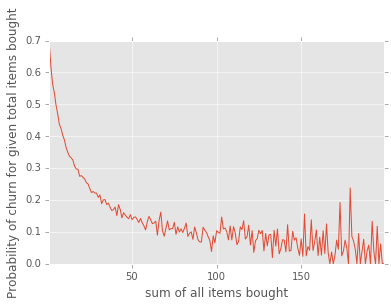

In [10]:
customer_order_sum_df[customer_order_sum_df.item_qty < 200].groupby("item_qty")["churn_label"].mean().plot()

plt.xlabel("sum of all items bought")
plt.ylabel("Probability of churn for given total items bought")

## Probability of churn decreases with total number of orders

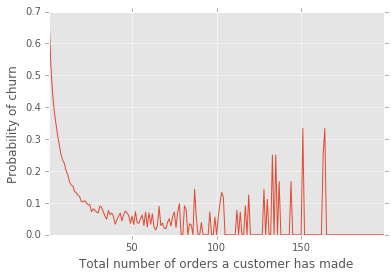

In [11]:
customer_order_sum_df[customer_order_sum_df.no_of_orders < 200].groupby("no_of_orders")["churn_label"].mean().plot()

plt.xlabel("Total number of orders a customer has made")
plt.ylabel("Probability of churn")

## Probability of churn decreases with total spend

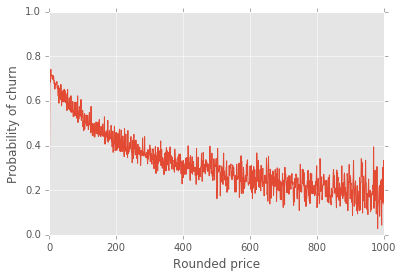

In [12]:
customer_order_sum_df[customer_order_sum_df.price < 1000].groupby("rounded_price")["churn_label"].mean().plot()

plt.xlabel("Rounded price")
plt.ylabel("Probability of churn")

In [13]:
customer_order_sum_df.round()["spent_last_month"].value_counts()

0.0       458003
20.0          61
18.0          59
30.0          50
25.0          50
40.0          46
22.0          45
28.0          43
14.0          39
16.0          38
12.0          36
50.0          35
26.0          34
8.0           32
24.0          31
15.0          30
10.0          30
38.0          28
36.0          27
45.0          26
32.0          24
60.0          24
21.0          24
42.0          23
34.0          22
55.0          22
35.0          20
65.0          19
6.0           19
46.0          19
           ...  
121.0          1
131.0          1
1110.0         1
135.0          1
171.0          1
175.0          1
238.0          1
180.0          1
237.0          1
233.0          1
232.0          1
226.0          1
225.0          1
222.0          1
221.0          1
218.0          1
217.0          1
216.0          1
136.0          1
212.0          1
211.0          1
208.0          1
207.0          1
204.0          1
201.0          1
199.0          1
196.0          1
191.0         

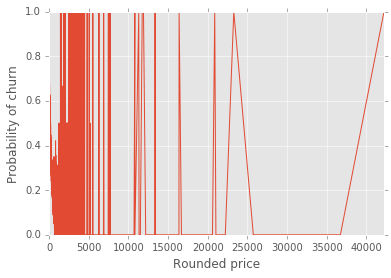

In [14]:
customer_order_sum_df.round().groupby("spent_last_year")["churn_label"].mean().plot()

plt.xlabel("Rounded price")
plt.ylabel("Probability of churn")

## Again churn drops dramatically after around a year, could be an artefact

Technically the customers who haven't ordered anything for a year should have already been classed as churned..

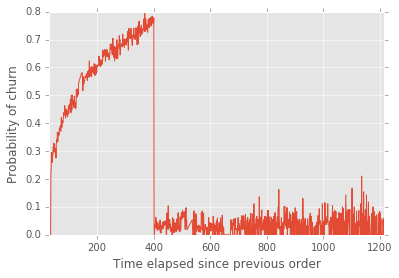

In [15]:
customer_order_sum_df.groupby("time_elapsed_since_last")["churn_label"].mean().plot()

plt.xlabel("Time elapsed since previous order")
plt.ylabel("Probability of churn")

## Add features from returns

In [88]:
#read returns data
returns_df = pd.read_table("returns/000000_0",header=None,names = ['customer_id','product_id',
                                                    'source_id','division_id','item_qty',
                                                    'signal_datetime','receipt_id', 'return_id',
                                                    'return_action','return_reason'])

#convert signal to datetime and get date
returns_df["signal_datetime"] = pd.to_datetime(returns_df["signal_datetime"])
returns_df["date"] = returns_df["signal_datetime"].dt.date

#add new column for each return action, 1 indicates that, that return action that was taken
returns_df["refunded"] = returns_df["return_action"].apply(lambda x : 1 if x == "Refund" else 0)
returns_df["cancelled"] = returns_df["return_action"].apply(lambda x : 1 if x == "Cancel" else 0)
returns_df["replaced"] = returns_df["return_action"].apply(lambda x : 1 if x == "Replacement" else 0)
returns_df["rejected"] = returns_df["return_action"].apply(lambda x : 1 if x == "Reject" else 0)

# create a summary dataframe of returns
returns_sum_df = returns_df.groupby(
    ['return_id','signal_datetime','customer_id']).sum().reset_index()

#drop columns that are now meaningless
returns_sum_df.drop(['product_id','source_id', 'division_id'], axis = 1, inplace = True)

#create a customer returns summary dataframe
customer_returns_sum_df = returns_sum_df.groupby("customer_id").sum().reset_index()

#rename sum of items returned as number of returned items
customer_returns_sum_df.rename(columns={'item_qty': 'no_returned_items'}, inplace=True)

#drop columns that are now meaningless
customer_returns_sum_df.drop(['return_id','receipt_id'], axis = 1, inplace = True)

##merge with customer order summary df
customer_order_sum_df = pd.merge(
    customer_order_sum_df,customer_returns_sum_df,on="customer_id",how='left')

## fill nulls in returned columns with zeroes (these customers have never returned an item)
customer_order_sum_df[
    ['no_returned_items', 'refunded', 'cancelled','replaced', 'rejected']] = customer_order_sum_df[
    ['no_returned_items', 'refunded', 'cancelled','replaced', 'rejected']].fillna(0)

customer_order_sum_df["bought_returned_ratio"] = \
    customer_order_sum_df["no_returned_items"]/customer_order_sum_df["no_of_orders"]
    
customer_order_sum_df["bought_returned_ratio_rounded"] = \
    np.rint(customer_order_sum_df["bought_returned_ratio"])

In [17]:
customer_order_sum_df.columns    


Index(['customer_id', 'item_qty', 'price', 'rounded_price', 'churn_label',
       'gender', 'country', 'date_created', 'YOB', 'premier', 'account_age',
       'account_age_months', 'customer_age', 'time_elapsed_since_last',
       'no_of_orders', 'orders_last_month', 'orders_last_6_month',
       'orders_last_year', 'spent_last_month', 'spent_last_6_month',
       'spent_last_year', 'no_returned_items', 'refunded', 'cancelled',
       'replaced', 'rejected', 'bought_returned_ratio',
       'bought_returned_ratio_rounded'],
      dtype='object')

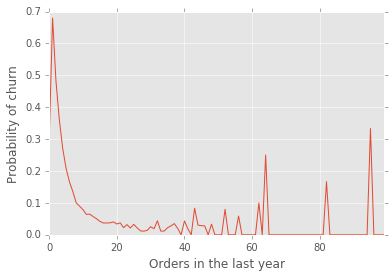

In [18]:
customer_order_sum_df[customer_order_sum_df["orders_last_year"] < 100].groupby("orders_last_year")["churn_label"].mean().plot()

plt.xlabel("Orders in the last year")
plt.ylabel("Probability of churn")

## Add browsing data

In [89]:
dfs_to_concat = []

for i in range(0,18):                                                            
    dfs_to_concat.append(
        pd.read_table("sessionsummary/0000%02d_0" % i,header=None,names = ['customer_id','country',
                                                            'start_time','site','page_views',
                                                            'non_page_view_events','user_agent',
                                                            'screen_res','browser_size','product_views',
                                                            'product_views_dist',
                                                            'added_to_bag','saved_for_l8r_prod',
                                                            'saved_for_l8r_cat','purchased_distinct',
                                                            'purchased_total']))
web_df = pd.concat(dfs_to_concat)

#drop website and browser info
web_df.drop(["site","user_agent","screen_res","browser_size"],axis = 1,inplace=True)

web_df["start_time"] = pd.to_datetime(web_df["start_time"])


##add time elapsed since last site view
latest_date = dt.datetime(2014,4,30)

#create time elapsed since last order feature
last_browse_df = pd.DataFrame(web_df.groupby("customer_id")["start_time"].max()).reset_index()

last_browse_df.rename(columns={'start_time': 'last_browse'}, inplace=True)

last_browse_df["time_since_last_browse"] = (latest_date - last_browse_df["last_browse"]).dt.days

site_visits = pd.DataFrame(web_df.groupby(["customer_id"])["country"].count()).reset_index()

site_visits.rename(columns={'country': 'total_site_visits'}, inplace=True)

#session_sum = pd.DataFrame(web_df.groupby(["customer_id"]).sum()).reset_index()


visits_last_month = web_df[web_df.start_time > one_month_ago].groupby(
    ["customer_id"])["start_time"].count().reset_index()

visits_last_month.rename(columns={'start_time': 'visits_last_month'}, inplace=True)

visits_last_3_months = web_df[web_df.start_time > three_months_ago].groupby(
    ["customer_id"])["start_time"].count().reset_index()

visits_last_3_months.rename(columns={'start_time': 'visits_last_3_month'}, inplace=True)

visits_last_6_months = web_df[web_df.start_time > six_months_ago].groupby(
    ["customer_id"])["start_time"].count().reset_index()

visits_last_6_months.rename(columns={'start_time': 'visits_last_6_month'}, inplace=True)

visits_last_year = web_df[web_df.start_time > one_year_ago].groupby(
    ["customer_id"])["start_time"].count().reset_index()

visits_last_year.rename(columns={'start_time': 'visits_last_year'}, inplace=True)


customer_order_sum_df = pd.merge(
    customer_order_sum_df,last_browse_df[["customer_id","time_since_last_browse"]],on="customer_id",how='left')

customer_order_sum_df = pd.merge(
    customer_order_sum_df,site_visits[["customer_id","total_site_visits"]],on="customer_id",how='left')

customer_order_sum_df = pd.merge(
    customer_order_sum_df,visits_last_month[["customer_id","visits_last_month"]],on="customer_id",how='left')

customer_order_sum_df = pd.merge(
    customer_order_sum_df,visits_last_3_months[["customer_id","visits_last_3_month"]],on="customer_id",how='left')

customer_order_sum_df = pd.merge(
    customer_order_sum_df,visits_last_6_months[["customer_id","visits_last_6_month"]],on="customer_id",how='left')

customer_order_sum_df = pd.merge(
    customer_order_sum_df,visits_last_year[["customer_id","visits_last_year"]],on="customer_id",how='left')


/home/duncan/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/duncan/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/duncan/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
visits_last_year[visits_last_year.visits_last_year > 3000]

,customer_id,visits_last_year
277683,1541352,4660


In [21]:
session_sum = pd.DataFrame(web_df.groupby(["customer_id"]).sum()).reset_index()

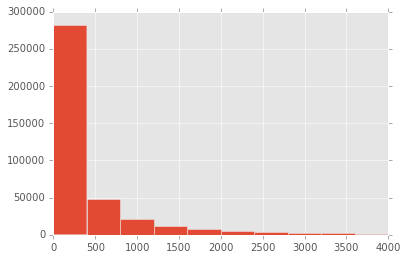

In [22]:
session_sum[session_sum["page_views"] < 4000]["page_views"].hist()

In [56]:
customer_order_sum_df = pd.merge(
   customer_order_sum_df,visits_last_month,on="customer_id",how='left')

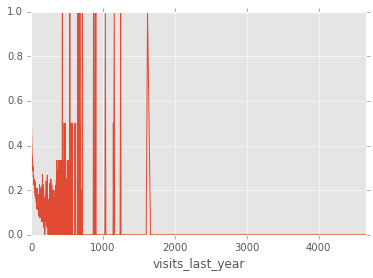

In [24]:
customer_order_sum_df.groupby("visits_last_year")["churn_label"].mean().plot()

In [90]:
customer_order_sum_df.columns

Index(['customer_id', 'item_qty', 'price', 'rounded_price', 'churn_label',
       'gender', 'country', 'date_created', 'YOB', 'premier', 'account_age',
       'account_age_months', 'customer_age', 'time_elapsed_since_last',
       'no_of_orders', 'orders_last_month', 'orders_last_2_month',
       'orders_last_3_month', 'orders_last_6_month', 'orders_last_year',
       'spent_last_month', 'spent_last_6_month', 'spent_last_year',
       'no_returned_items', 'refunded', 'cancelled', 'replaced', 'rejected',
       'bought_returned_ratio', 'bought_returned_ratio_rounded',
       'time_since_last_browse', 'total_site_visits', 'visits_last_month',
       'visits_last_3_month', 'visits_last_6_month', 'visits_last_year'],
      dtype='object')

In [1]:
y, X = dmatrices('churn_label ~ price + C(premier) + account_age \
           + account_age_months + customer_age + time_elapsed_since_last \
           + no_of_orders + orders_last_month + orders_last_2_month \
           + orders_last_3_month + orders_last_6_month + orders_last_year \
           + spent_last_month + spent_last_6_month + spent_last_year \
           + no_returned_items + refunded + cancelled + replaced + rejected \
           + bought_returned_ratio',
                  customer_order_sum_df, return_type="dataframe")


scaler = StandardScaler()
X = scaler.fit_transform(X)


#clf = RandomForestClassifier(n_estimators=50, 
#                             max_depth =14, min_samples_leaf = 11, max_features = 7,
#                            criterion = 'entropy', min_samples_split = 14, bootstrap = True)

#clf = ExtraTreesClassifier()

clf = LogisticRegression()

y = np.ravel(y)

#print((cross_val_score(clf, X, y,cv=3,n_jobs=-1)).mean())

accuracy = cross_val_score(clf, X, y, cv=4,n_jobs=-1)
precision = cross_val_score(clf, X, y, cv=4, scoring='precision',n_jobs=-1)
recall = cross_val_score(clf, X, y, cv=4, scoring='recall',n_jobs=-1)

print('accuracy: ',accuracy)
print('precision: ',precision)
print('recall: ',recall)

#print(clf.feature_importances_)
# create the RFE model and select 3 attributes
#rfe = RFE(clf,3)
#rfe = rfe.fit(X_train,y_train)
# summarize the selection of the attributes
#print(rfe.support_)
#print(rfe.ranking_)

NameError: name 'dmatrices' is not defined

[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Cell ran in  1912.0731177330017
Optimal number of features : 27


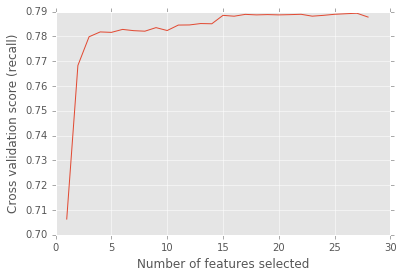

In [100]:
start = time()
#create the RFE model and select 3 attributes
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=clf, step=1, scoring='recall', n_jobs=-1)
rfecv = rfecv.fit(X,y)
#summarize the selection of the attributes
print(rfecv.support_)
print(rfecv.ranking_)

print('Cell ran in ', time() - start)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (recall)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [103]:
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": sp_randint(3, 30),
              "max_features": sp_randint(1, 27),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 20),}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring=make_scorer(recall_score),n_jobs=-1)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 3542.20 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.790 (std: 0.001)
Parameters: {'max_depth': 15, 'min_samples_split': 14, 'max_features': 7, 'min_samples_leaf': 11}

Model with rank: 2
Mean validation score: 0.790 (std: 0.000)
Parameters: {'max_depth': 14, 'min_samples_split': 6, 'max_features': 4, 'min_samples_leaf': 16}

Model with rank: 3
Mean validation score: 0.789 (std: 0.000)
Parameters: {'max_depth': 23, 'min_samples_split': 13, 'max_features': 5, 'min_samples_leaf': 14}



In [49]:
sp_randint(1, 20)

In [46]:
# use a full grid over all parameters
param_grid = {"max_depth": [15, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, scoring=make_scorer(recall_score),n_jobs=-1)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 16367.80 seconds for 216 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.788 (std: 0.002)
Parameters: {'max_depth': 15, 'max_features': 3, 'min_samples_leaf': 10, 'criterion': 'entropy', 'min_samples_split': 2, 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.788 (std: 0.001)
Parameters: {'max_depth': 15, 'max_features': 3, 'min_samples_leaf': 1, 'criterion': 'entropy', 'min_samples_split': 10, 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.788 (std: 0.002)
Parameters: {'max_depth': 15, 'max_features': 3, 'min_samples_leaf': 10, 'criterion': 'entropy', 'min_samples_split': 10, 'bootstrap': True}

